# Method 8 - Best Ideas Low Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] > qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

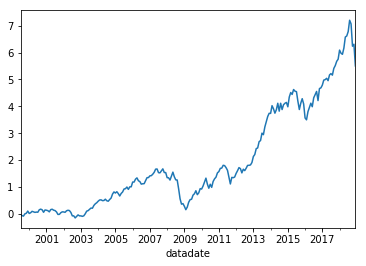

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.099808
2000-12-31    0.037008
2001-12-31   -0.060938
2002-12-31   -0.140098
2003-12-31    0.530424
2004-12-31    0.285868
2005-12-31    0.105531
2006-12-31    0.171597
2007-12-31    0.079075
2008-12-31   -0.456137
2009-12-31    0.405106
2010-12-31    0.302672
2011-12-31   -0.060943
2012-12-31    0.227270
2013-12-31    0.631215
2014-12-31    0.085309
2015-12-31   -0.010959
2016-12-31    0.117428
2017-12-31    0.187881
2018-12-31   -0.037093
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     367.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.98e-98
Time:                        07:03:16   Log-Likelihood:                 594.97
No. Observations:                 234   AIC:                            -1180.
Df Residuals:                     229   BIC:                            -1163.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.040      0.043    9.12e-05       0.005
mktrf          1.1092      0.036     30.909      0.000       1.038       1.180
me             0.2978      0.042      7.135      0.000       0.216       0.380
ia             0.2956      0.063      4.659      0.000       0.171       0.421
roe            0.1476      0.054      2.718      0.007       0.041       0.255
==============================================================================
Omnibus:                        6.037   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                6.497
Skew:                          -0.259   Prob(JB):                       0.0388
Kurtosis:                       3.631   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     817.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.87e-134
Time:                        07:03:16   Log-Likelihood:                 594.97
No. Observations:                 234   AIC:                            -1180.
Df Residuals:                     229   BIC:                            -1163.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.247      0.025       0.000       0.005
mktrf          1.1092      0.049     22.823      0.000       1.014       1.204
me             0.2978      0.105      2.835      0.005       0.092       0.504
ia             0.2956      0.122      2.433      0.015       0.057       0.534
roe            0.1476      0.068      2.158      0.031       0.014       0.282
==============================================================================
Omnibus:                        6.037   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                6.497
Skew:                          -0.259   Prob(JB):                       0.0388
Kurtosis:                       3.631   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1326.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.58e-157
Time:                        07:03:16   Log-Likelihood:                 594.97
No. Observations:                 234   AIC:                            -1180.
Df Residuals:                     229   BIC:                            -1163.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.506      0.012       0.001       0.005
mktrf          1.1092      0.049     22.497      0.000       1.013       1.206
me             0.2978      0.108      2.748      0.006       0.085       0.510
ia             0.2956      0.143      2.068      0.039       0.015       0.576
roe            0.1476      0.077      1.920      0.055      -0.003       0.298
==============================================================================
Omnibus:                        6.037   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                6.497
Skew:                          -0.259   Prob(JB):                       0.0388
Kurtosis:                       3.631   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     295.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.91e-97
Time:                        07:03:16   Log-Likelihood:                 595.74
No. Observations:                 234   AIC:                            -1179.
Df Residuals:                     228   BIC:                            -1159.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.871      0.063      -0.000       0.005
mktrf          1.0940      0.036     30.460      0.000       1.023       1.165
smb            0.3510      0.047      7.406      0.000       0.258       0.444
hml            0.1376      0.056      2.462      0.015       0.027       0.248
rmw            0.1709      0.063      2.705      0.007       0.046       0.295
cma            0.1024      0.080      1.275      0.204      -0.056       0.261
==============================================================================
Omnibus:                        7.943   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.133
Skew:                          -0.259   Prob(JB):                      0.00631
Kurtosis:                       3.878   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     553.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.65e-125
Time:                        07:03:16   Log-Likelihood:                 595.74
No. Observations:                 234   AIC:                            -1179.
Df Residuals:                     228   BIC:                            -1159.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.838      0.066      -0.000       0.005
mktrf          1.0940      0.042     26.130      0.000       1.012       1.176
smb            0.3510      0.090      3.921      0.000       0.176       0.526
hml            0.1376      0.103      1.339      0.181      -0.064       0.339
rmw            0.1709      0.071      2.418      0.016       0.032       0.309
cma            0.1024      0.122      0.836      0.403      -0.138       0.342
==============================================================================
Omnibus:                        7.943   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.133
Skew:                          -0.259   Prob(JB):                      0.00631
Kurtosis:                       3.878   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1009.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.62e-153
Time:                        07:03:16   Log-Likelihood:                 595.74
No. Observations:                 234   AIC:                            -1179.
Df Residuals:                     228   BIC:                            -1159.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.932      0.053    -3.6e-05       0.005
mktrf          1.0940      0.040     27.609      0.000       1.016       1.172
smb            0.3510      0.104      3.369      0.001       0.147       0.555
hml            0.1376      0.110      1.250      0.211      -0.078       0.353
rmw            0.1709      0.067      2.550      0.011       0.040       0.302
cma            0.1024      0.124      0.826      0.409      -0.141       0.345
==============================================================================
Omnibus:                        7.943   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.133
Skew:                          -0.259   Prob(JB):                      0.00631
Kurtosis:                       3.878   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     362.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.67e-98
Time:                        07:03:16   Log-Likelihood:                 593.58
No. Observations:                 234   AIC:                            -1177.
Df Residuals:                     229   BIC:                            -1160.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.426      0.016       0.001       0.006
mktrf          1.0920      0.033     32.856      0.000       1.027       1.157
smb            0.2257      0.041      5.439      0.000       0.144       0.307
hml            0.3139      0.041      7.617      0.000       0.233       0.395
umd            0.0994      0.027      3.674      0.000       0.046       0.153
==============================================================================
Omnibus:                       11.413   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.625
Skew:                          -0.297   Prob(JB):                     0.000149
Kurtosis:                       4.206   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     563.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.44e-117
Time:                        07:03:16   Log-Likelihood:                 593.58
No. Observations:                 234   AIC:                            -1177.
Df Residuals:                     229   BIC:                            -1160.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.455      0.014       0.001       0.006
mktrf          1.0920      0.037     29.421      0.000       1.019       1.165
smb            0.2257      0.110      2.051      0.040       0.010       0.441
hml            0.3139      0.092      3.430      0.001       0.135       0.493
umd            0.0994      0.046      2.140      0.032       0.008       0.190
==============================================================================
Omnibus:                       11.413   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.625
Skew:                          -0.297   Prob(JB):                     0.000149
Kurtosis:                       4.206   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     744.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.75e-130
Time:                        07:03:17   Log-Likelihood:                 593.58
No. Observations:                 234   AIC:                            -1177.
Df Residuals:                     229   BIC:                            -1160.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.732      0.006       0.001       0.005
mktrf          1.0920      0.030     36.492      0.000       1.033       1.151
smb            0.2257      0.124      1.827      0.068      -0.016       0.468
hml            0.3139      0.103      3.041      0.002       0.112       0.516
umd            0.0994      0.038      2.642      0.008       0.026       0.173
==============================================================================
Omnibus:                       11.413   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.625
Skew:                          -0.297   Prob(JB):                     0.000149
Kurtosis:                       4.206   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     204.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.72e-51
Time:                        07:03:17   Log-Likelihood:                 304.56
No. Observations:                 120   AIC:                            -599.1
Df Residuals:                     115   BIC:                            -585.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.707      0.091      -0.001       0.007
mktrf          1.1926      0.050     23.688      0.000       1.093       1.292
me             0.1982      0.050      3.986      0.000       0.100       0.297
ia             0.3625      0.078      4.656      0.000       0.208       0.517
roe            0.2815      0.069      4.085      0.000       0.145       0.418
==============================================================================
Omnibus:                        1.138   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.683
Skew:                          -0.069   Prob(JB):                        0.711
Kurtosis:                       3.343   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     581.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.72e-75
Time:                        07:03:17   Log-Likelihood:                 304.56
No. Observations:                 120   AIC:                            -599.1
Df Residuals:                     115   BIC:                            -585.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.167      0.030       0.000       0.006
mktrf          1.1926      0.050     23.770      0.000       1.094       1.291
me             0.1982      0.073      2.716      0.007       0.055       0.341
ia             0.3625      0.114      3.175      0.001       0.139       0.586
roe            0.2815      0.069      4.057      0.000       0.146       0.418
==============================================================================
Omnibus:                        1.138   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.683
Skew:                          -0.069   Prob(JB):                        0.711
Kurtosis:                       3.343   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     905.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.60e-86
Time:                        07:03:17   Log-Likelihood:                 304.56
No. Observations:                 120   AIC:                            -599.1
Df Residuals:                     115   BIC:                            -585.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.504      0.012       0.001       0.006
mktrf          1.1926      0.041     28.741      0.000       1.111       1.274
me             0.1982      0.077      2.583      0.010       0.048       0.349
ia             0.3625      0.123      2.937      0.003       0.121       0.604
roe            0.2815      0.059      4.743      0.000       0.165       0.398
==============================================================================
Omnibus:                        1.138   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.683
Skew:                          -0.069   Prob(JB):                        0.711
Kurtosis:                       3.343   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     138.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.63e-47
Time:                        07:03:17   Log-Likelihood:                 296.37
No. Observations:                 120   AIC:                            -580.7
Df Residuals:                     114   BIC:                            -564.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.616      0.109      -0.001       0.007
mktrf          1.1696      0.057     20.487      0.000       1.056       1.283
smb            0.2439      0.065      3.772      0.000       0.116       0.372
hml            0.0557      0.079      0.703      0.483      -0.101       0.213
rmw            0.2639      0.093      2.825      0.006       0.079       0.449
cma            0.2549      0.102      2.491      0.014       0.052       0.458
==============================================================================
Omnibus:                        1.536   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.168
Skew:                          -0.232   Prob(JB):                        0.558
Kurtosis:                       3.134   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     263.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.49e-61
Time:                        07:03:17   Log-Likelihood:                 296.37
No. Observations:                 120   AIC:                            -580.7
Df Residuals:                     114   BIC:                            -564.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.778      0.075      -0.000       0.007
mktrf          1.1696      0.067     17.465      0.000       1.038       1.301
smb            0.2439      0.094      2.596      0.009       0.060       0.428
hml            0.0557      0.136      0.411      0.681      -0.210       0.321
rmw            0.2639      0.137      1.929      0.054      -0.004       0.532
cma            0.2549      0.111      2.306      0.021       0.038       0.472
==============================================================================
Omnibus:                        1.536   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.168
Skew:                          -0.232   Prob(JB):                        0.558
Kurtosis:                       3.134   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     343.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.73e-67
Time:                        07:03:17   Log-Likelihood:                 296.37
No. Observations:                 120   AIC:                            -580.7
Df Residuals:                     114   BIC:                            -564.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      2.093      0.036       0.000       0.006
mktrf          1.1696      0.066     17.786      0.000       1.041       1.298
smb            0.2439      0.111      2.207      0.027       0.027       0.461
hml            0.0557      0.150      0.372      0.710      -0.238       0.349
rmw            0.2639      0.147      1.798      0.072      -0.024       0.552
cma            0.2549      0.106      2.399      0.016       0.047       0.463
==============================================================================
Omnibus:                        1.536   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.168
Skew:                          -0.232   Prob(JB):                        0.558
Kurtosis:                       3.134   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     168.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.84e-47
Time:                        07:03:17   Log-Likelihood:                 294.56
No. Observations:                 120   AIC:                            -579.1
Df Residuals:                     115   BIC:                            -565.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      2.623      0.010       0.001       0.009
mktrf          1.1166      0.048     23.162      0.000       1.021       1.212
smb            0.0860      0.055      1.566      0.120      -0.023       0.195
hml            0.3182      0.055      5.788      0.000       0.209       0.427
umd            0.1136      0.034      3.350      0.001       0.046       0.181
==============================================================================
Omnibus:                        4.790   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                5.408
Skew:                          -0.219   Prob(JB):                       0.0669
Kurtosis:                       3.944   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     307.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.06e-60
Time:                        07:03:17   Log-Likelihood:                 294.56
No. Observations:                 120   AIC:                            -579.1
Df Residuals:                     115   BIC:                            -565.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      3.429      0.001       0.002       0.008
mktrf          1.1166      0.056     19.772      0.000       1.006       1.227
smb            0.0860      0.086      1.002      0.316      -0.082       0.254
hml            0.3182      0.104      3.060      0.002       0.114       0.522
umd            0.1136      0.052      2.199      0.028       0.012       0.215
==============================================================================
Omnibus:                        4.790   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                5.408
Skew:                          -0.219   Prob(JB):                       0.0669
Kurtosis:                       3.944   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     384.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.60e-65
Time:                        07:03:17   Log-Likelihood:                 294.56
No. Observations:                 120   AIC:                            -579.1
Df Residuals:                     115   BIC:                            -565.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.001      4.284      0.000       0.003       0.008
mktrf          1.1166      0.044     25.551      0.000       1.031       1.202
smb            0.0860      0.093      0.919      0.358      -0.097       0.269
hml            0.3182      0.114      2.802      0.005       0.096       0.541
umd            0.1136      0.038      2.992      0.003       0.039       0.188
==============================================================================
Omnibus:                        4.790   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                5.408
Skew:                          -0.219   Prob(JB):                       0.0669
Kurtosis:                       3.944   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     433.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.02e-66
Time:                        07:03:17   Log-Likelihood:                 344.23
No. Observations:                 114   AIC:                            -678.5
Df Residuals:                     109   BIC:                            -664.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      3.672      0.000       0.002       0.007
mktrf          0.9641      0.036     27.144      0.000       0.894       1.035
me             0.6251      0.055     11.398      0.000       0.516       0.734
ia            -0.1038      0.076     -1.364      0.175      -0.255       0.047
roe           -0.3253      0.067     -4.866      0.000      -0.458      -0.193
==============================================================================
Omnibus:                        1.951   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.377   Jarque-Bera (JB):                1.445
Skew:                           0.015   Prob(JB):                        0.486
Kurtosis:                       2.449   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     611.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.21e-73
Time:                        07:03:17   Log-Likelihood:                 344.23
No. Observations:                 114   AIC:                            -678.5
Df Residuals:                     109   BIC:                            -664.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      3.194      0.001       0.002       0.007
mktrf          0.9641      0.029     33.806      0.000       0.908       1.020
me             0.6251      0.051     12.158      0.000       0.524       0.726
ia            -0.1038      0.091     -1.143      0.253      -0.282       0.074
roe           -0.3253      0.069     -4.696      0.000      -0.461      -0.190
==============================================================================
Omnibus:                        1.951   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.377   Jarque-Bera (JB):                1.445
Skew:                           0.015   Prob(JB):                        0.486
Kurtosis:                       2.449   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     953.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.45e-84
Time:                        07:03:17   Log-Likelihood:                 344.23
No. Observations:                 114   AIC:                            -678.5
Df Residuals:                     109   BIC:                            -664.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.865      0.004       0.001       0.007
mktrf          0.9641      0.025     38.251      0.000       0.915       1.014
me             0.6251      0.052     11.967      0.000       0.523       0.727
ia            -0.1038      0.101     -1.030      0.303      -0.301       0.094
roe           -0.3253      0.064     -5.072      0.000      -0.451      -0.200
==============================================================================
Omnibus:                        1.951   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.377   Jarque-Bera (JB):                1.445
Skew:                           0.015   Prob(JB):                        0.486
Kurtosis:                       2.449   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     419.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.07e-69
Time:                        07:03:17   Log-Likelihood:                 355.00
No. Observations:                 114   AIC:                            -698.0
Df Residuals:                     108   BIC:                            -681.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      2.951      0.004       0.001       0.005
mktrf          0.9973      0.031     32.207      0.000       0.936       1.059
smb            0.6034      0.050     12.004      0.000       0.504       0.703
hml           -0.0058      0.064     -0.091      0.928      -0.133       0.121
rmw           -0.4000      0.079     -5.096      0.000      -0.556      -0.244
cma           -0.1342      0.100     -1.346      0.181      -0.332       0.063
==============================================================================
Omnibus:                        0.576   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.750   Jarque-Bera (JB):                0.720
Skew:                          -0.126   Prob(JB):                        0.698
Kurtosis:                       2.703   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     482.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.86e-72
Time:                        07:03:18   Log-Likelihood:                 355.00
No. Observations:                 114   AIC:                            -698.0
Df Residuals:                     108   BIC:                            -681.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      2.707      0.007       0.001       0.006
mktrf          0.9973      0.024     42.022      0.000       0.951       1.044
smb            0.6034      0.058     10.376      0.000       0.489       0.717
hml           -0.0058      0.055     -0.105      0.916      -0.114       0.102
rmw           -0.4000      0.065     -6.153      0.000      -0.527      -0.273
cma           -0.1342      0.106     -1.262      0.207      -0.343       0.074
==============================================================================
Omnibus:                        0.576   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.750   Jarque-Bera (JB):                0.720
Skew:                          -0.126   Prob(JB):                        0.698
Kurtosis:                       2.703   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     559.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.78e-75
Time:                        07:03:18   Log-Likelihood:                 355.00
No. Observations:                 114   AIC:                            -698.0
Df Residuals:                     108   BIC:                            -681.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      2.414      0.016       0.001       0.006
mktrf          0.9973      0.024     40.959      0.000       0.950       1.045
smb            0.6034      0.058     10.350      0.000       0.489       0.718
hml           -0.0058      0.049     -0.119      0.905      -0.102       0.090
rmw           -0.4000      0.069     -5.815      0.000      -0.535      -0.265
cma           -0.1342      0.093     -1.437      0.151      -0.317       0.049
==============================================================================
Omnibus:                        0.576   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.750   Jarque-Bera (JB):                0.720
Skew:                          -0.126   Prob(JB):                        0.698
Kurtosis:                       2.703   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     422.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.25e-65
Time:                        07:03:18   Log-Likelihood:                 342.85
No. Observations:                 114   AIC:                            -675.7
Df Residuals:                     109   BIC:                            -662.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.564      0.121      -0.001       0.004
mktrf          1.0438      0.034     30.636      0.000       0.976       1.111
smb            0.6865      0.053     12.922      0.000       0.581       0.792
hml            0.0842      0.055      1.538      0.127      -0.024       0.193
umd            0.0758      0.041      1.837      0.069      -0.006       0.158
==============================================================================
Omnibus:                        0.903   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                1.017
Skew:                          -0.170   Prob(JB):                        0.601
Kurtosis:                       2.685   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     751.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.44e-78
Time:                        07:03:18   Log-Likelihood:                 342.85
No. Observations:                 114   AIC:                            -675.7
Df Residuals:                     109   BIC:                            -662.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.304      0.192      -0.001       0.005
mktrf          1.0438      0.023     45.229      0.000       0.999       1.089
smb            0.6865      0.058     11.779      0.000       0.572       0.801
hml            0.0842      0.060      1.408      0.159      -0.033       0.201
umd            0.0758      0.033      2.272      0.023       0.010       0.141
==============================================================================
Omnibus:                        0.903   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                1.017
Skew:                          -0.170   Prob(JB):                        0.601
Kurtosis:                       2.685   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     996.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.99e-85
Time:                        07:03:18   Log-Likelihood:                 342.85
No. Observations:                 114   AIC:                            -675.7
Df Residuals:                     109   BIC:                            -662.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.182      0.237      -0.001       0.005
mktrf          1.0438      0.023     46.173      0.000       0.999       1.088
smb            0.6865      0.053     12.904      0.000       0.582       0.791
hml            0.0842      0.064      1.314      0.189      -0.041       0.210
umd            0.0758      0.031      2.412      0.016       0.014       0.137
==============================================================================
Omnibus:                        0.903   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                1.017
Skew:                          -0.170   Prob(JB):                        0.601
Kurtosis:                       2.685   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""